# Demonstration of KPP optimiation in the `ColumnModelOptimizationProject`

In this notebook we demonstrate the optimization of KPP for free convection.

We consider a case with wind-driven shear mixing and neutral buoyancy forcing.

In [9]:
using Pkg; Pkg.activate("..")

using PyPlot, Printf, StaticArrays
using OceanTurb, Dao, ColumnModelOptimizationProject, ColumnModelOptimizationProject.KPPOptimization

cases = ["free_convection", "shear_neutral", "shear_unstable", "shear_stable"]

datadir = joinpath("..", "data", "idealized")
dirs = Dict((c, joinpath(datadir, c)) for c in cases)

examples = Dict(
    "free_convection" => "wind_stress_N256_tau0_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_neutral"   => "wind_stress_N256_tau0.1_Q0_dTdz0.001_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_unstable"  => "wind_stress_N256_tau0.1_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_stable"    => "wind_stress_N256_tau0.04_Q10_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2" 
)

examplepaths = Dict((c, joinpath(dirs[c], examples[c])) for c in cases)

Dict{String,String} with 4 entries:
  "shear_unstable"  => "../data/idealized/shear_unstable/wind_stress_N256_tau0.…
  "shear_stable"    => "../data/idealized/shear_stable/wind_stress_N256_tau0.04…
  "free_convection" => "../data/idealized/free_convection/wind_stress_N256_tau0…
  "shear_neutral"   => "../data/idealized/shear_neutral/wind_stress_N256_tau0.1…

# The model and the data

First we instantiate our column data and our column model. 

The object `ColumnData` stores a time-series of one-dimensional profiles, physical constants, and other metadata needed to build a one-dimensional column model intended to approximate the data.
In addition, we specify the time-series indices of the initial profile and target profiles to which the `model` will be optimized.

The object `ColumnModel` stores the numerical model (typically of the type `OceanTurb.AbstractModel`) and the time-step `\Delta t`.
We use a constructor from `KPPOptimization` which uses the numerical model `KPP.Model` with time-step 10 minutes and resolution `N=10`.

In [28]:
column_data = ColumnData(examplepaths["free_convection"]; initial=8, targets=(16, 24, 32))
column_model = KPPOptimization.ColumnModel(column_data, 10*minute, N=20)

@show initial_time(column_data)/day target_times(column_data)./day;

initial_time(column_data) / day = 1.3125
target_times(column_data) ./ day = [2.8125, 4.3125, 5.8125]


# Choosing a set of free parameters

The `ColumnModelOptimizationProject` provides a number of sets of free parameters that may be optimized.
Additionally, the user can specify additional free parameters by subtyping `FreeParameters{N, T}`, where `N`
is the number of free parameters and `T` is the type (typically `Float64`).
    
Here, we define a struct with just one free parameter, the unresolved kinetic energy constant.
Note that the struct must be `mutable` because of the way we compute perturbations to the free parameters.

In [29]:
mutable struct UnresolvedKineticEnergyParameter{T} <: FreeParameters{1, T}
    CKE :: T
end

# Pre-optimization visualization of data and model

To visualize both the data and the model for a particular choice of parameters, we use the
`visualize_realization` function. Here we visualize the default parameters obtained by
calling the constructor `DefaultFreeParameters` with the type of the `FreeParameters` struct as
an argument. `DefaultFreeParameters` draws the default parameters from the module in `OceanTurb.jl`.
The default parameters form the initial condition for our optimization routine.

Here we see that KPP already does the free convection case quite well. With optimization we can do slightly better.

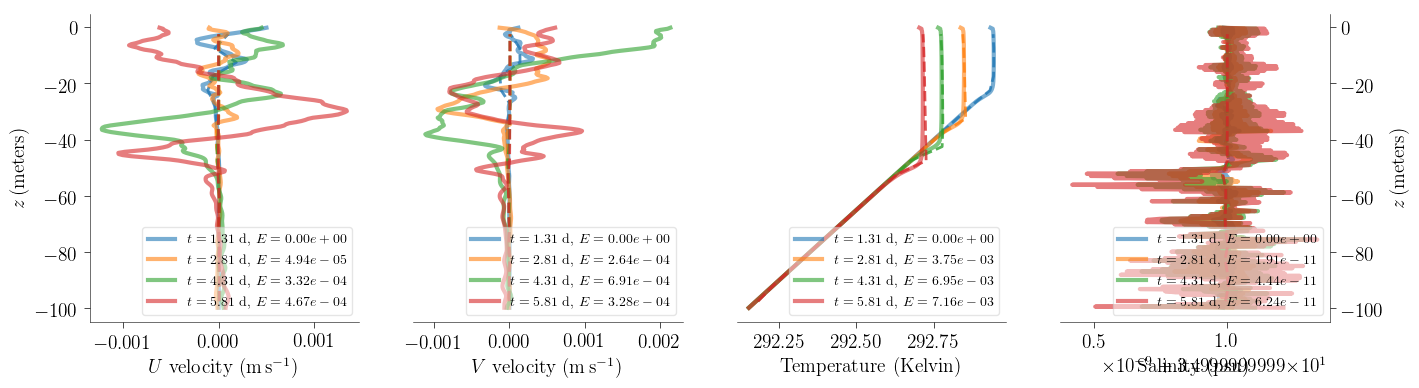

defaults = [4.32]


(Figure(PyObject <Figure size 1600x400 with 4 Axes>), PyCall.PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x13edc5ef0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1240f3eb8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x13f287470>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x13f2ae9e8>])

In [30]:
defaults = DefaultFreeParameters(UnresolvedKineticEnergyParameter)
@show defaults

fig, axs = visualize_realization(defaults, column_model, column_data; legendkwargs=Dict(:loc=>4))

# The 'Negative Log Likelihood' function

Next we define a simple function to compute the negative log likelihood.
We do not specify a prior, which indicates the default setting of an 'uninformative prior'.
We use a loss function based on the difference between model and data temperature profiles.
, as well as a
`sampler` that uses the Metropolis algorithm with normally distributed random perturbations
for proposal parameter vectors.

In [31]:
nll = NegativeLogLikelihood(column_model, column_data, temperature_loss)
first_link = MarkovLink(nll, defaults)

@show first_link.error;

first_link.error = 0.005953261979492269


# Initializing the Markov Chain

We show here how to fiddle with parameters associated with the Metropolis algorithm to obtain a good acceptance ratio and Markov chain.

We use a `NonNegativeNormalPerturbation` for our random walk, which prevents parameters from becoming negative by
filtering the parameters with a hard maximum of the form `max(0, param)`.
We choose a standard deviation that is 10\% the size of the default parameter in `OceanTurb.jl` for our normally-distributed perturbations.

In [32]:
nll.scale = first_link.error * 0.1
first_link = MarkovLink(nll, defaults)
@show first_link.error

std = DefaultStdFreeParameters(0.1, typeof(defaults))
sampler = MetropolisSampler(NonNegativeNormalPerturbation(std));

@time chain = MarkovChain(10^2, first_link, nll, sampler)
@show chain.acceptance

first_link.error = 0.005953261979492269
  4.332934 seconds (85.67 M allocations: 1.293 GiB, 5.33% gc time)
chain.acceptance = 0.3939393939393939


0.3939393939393939

# Extending the Markov Chain

Next we extend the Markov Chain and plot the results.

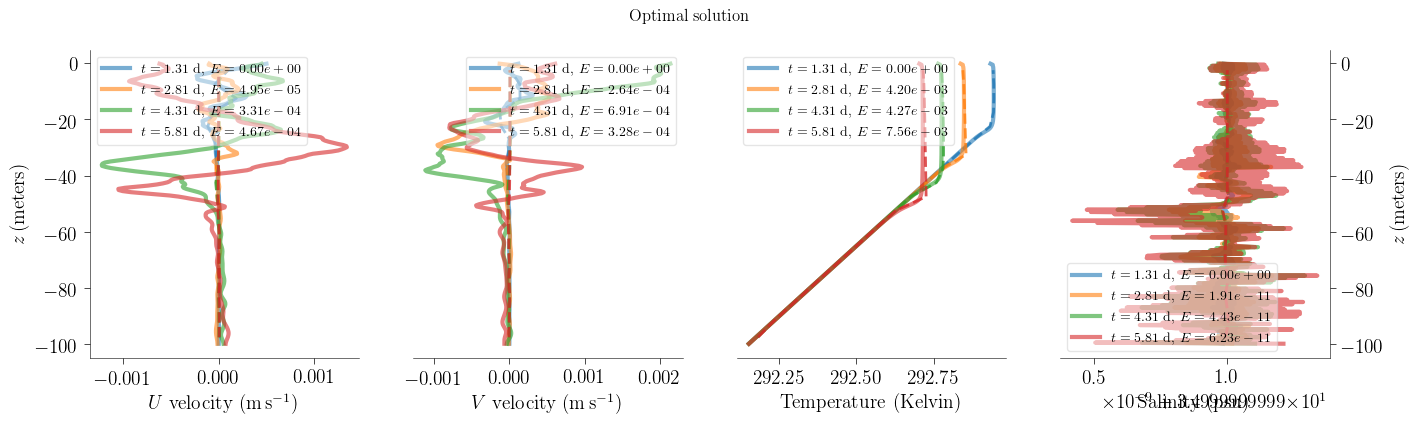

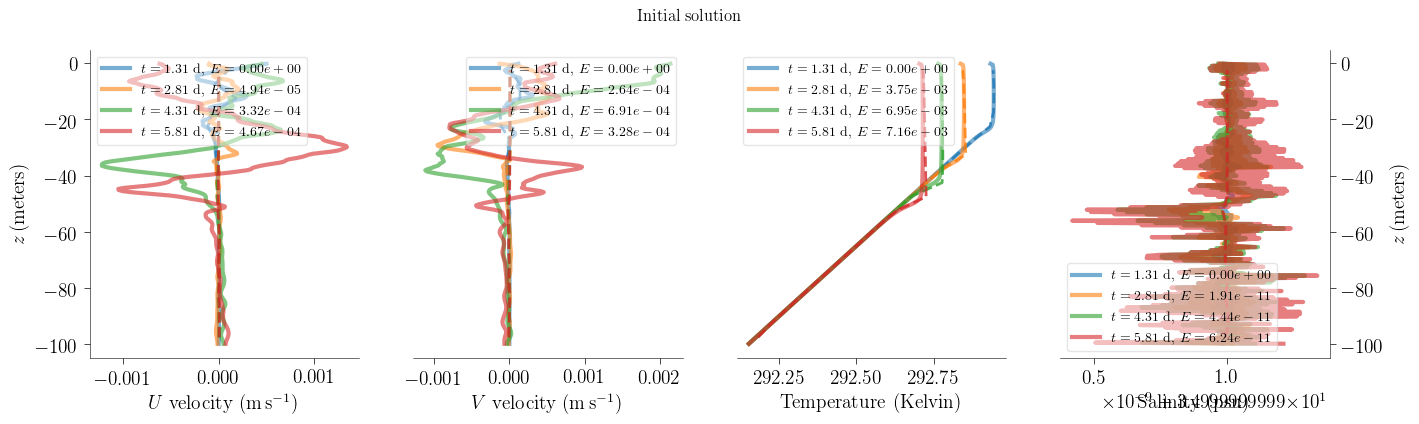

414.779797 seconds (9.00 G allocations: 135.701 GiB, 5.50% gc time)
chain.acceptance = 0.011387266065947123
(chain.links[1]).param = [4.32]
optimal_param = [3.99639]
(chain.links[1]).error = 0.005953261979492269
optimal_error = 0.00534572296547491


PyObject Text(0.5, 0.98, 'Initial solution')

In [33]:
@time extend!(chain, 10^4)

errs = errors(chain)
optimal_param, optimal_error = optimal(chain)

@show chain.acceptance # acceptance ratio
@show chain.links[1].param optimal_param # initial parameter and 'optimal' parameter
@show chain.links[1].error optimal_error # initial error and error with optimal parameter choice

fig, axs = visualize_realization(optimal_param, column_model, column_data)
fig.suptitle("Optimal solution")

fig, axs = visualize_realization(chain.links[1].param, column_model, column_data)
fig.suptitle("Initial solution")